In [71]:
import nltk
import string
import re
from nltk import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', 100)

#### Read the data file with tab delimiter and provide the column names for the dataframe

In [72]:
data = pd.read_csv('SMSSpamCollection.tsv', sep='\t', names=['label', 'body_text'])
data.head()

,label,body_text
0,ham,I've been searching for the right words to thank you for this breather. I promise i wont take yo...
1,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...
2,ham,"Nah I don't think he goes to usf, he lives around here though"
3,ham,Even my brother is not like to speak with me. They treat me like aids patent.
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!


#### Hypothesis 1 - Spam messages are longer than non spam messages
#### Hypothesis 2 - Spam messages have more punctuation than non spam messages

##### Create a new feature for length of the text

In [76]:
data['text_length'] = data['body_text'].apply(lambda x: len(x) - x.count(" ") )

##### Create a new feature for percentage of punctuation in the text

In [77]:
def get_punct_percentage(text):
    """Returns the % of punctuation in the text"""
    percentage = sum([1 for char in text if char in string.punctuation])/(len(text) - text.count(" "))
    return round(percentage * 100,3)

data['punct%'] = data['body_text'].apply(lambda x: get_punct_percentage(x))
data.head()

,label,body_text,text_length,punct%
0,ham,I've been searching for the right words to thank you for this breather. I promise i wont take yo...,160,2.500
1,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,128,4.688
2,ham,"Nah I don't think he goes to usf, he lives around here though",49,4.082
3,ham,Even my brother is not like to speak with me. They treat me like aids patent.,62,3.226
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,28,7.143


### Visualize the distribution of these newly created features w.r.t spam and ham

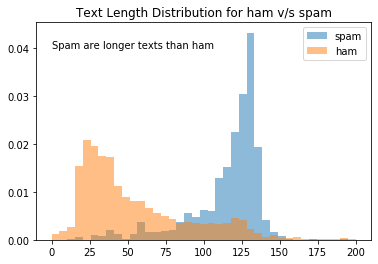

In [78]:
bins_to_use = np.linspace(0, 200, 40)
plt.hist(data[data.label == 'spam']['text_length'], bins=bins_to_use, alpha=0.5, density=True, label='spam')
plt.hist(data[data.label == 'ham']['text_length'], bins=bins_to_use, alpha=0.5, density=True, label='ham')
plt.legend()
plt.title('Text Length Distribution for ham v/s spam')
plt.annotate('Spam are longer texts than ham', xy=(0, 0.04))
plt.show()

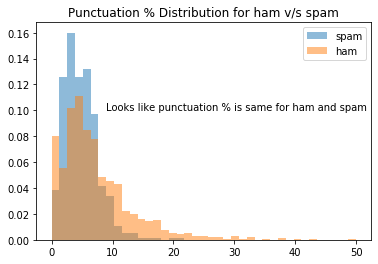

In [79]:
bins_to_use = np.linspace(0, 50, 40)
plt.hist(data[data.label == 'spam']['punct%'], bins=bins_to_use, alpha=0.5, density=True, label='spam')
plt.hist(data[data.label == 'ham']['punct%'], bins=bins_to_use, alpha=0.5, density=True, label='ham')
plt.legend()
plt.title('Punctuation % Distribution for ham v/s spam')
plt.annotate('Looks like punctuation % is same for ham and spam', xy=(9, 0.1))
plt.show()

#### Now let's see which of these new features may be a candidate for feature transformation.

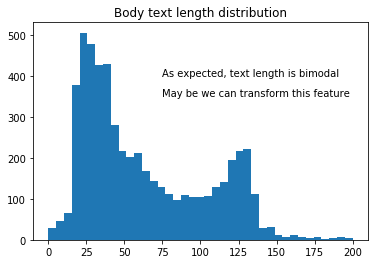

In [85]:
bins_to_use = np.linspace(0, 200, 40)
plt.hist(data['text_length'], bins=bins_to_use)
plt.title('Body text length distribution')
plt.annotate('As expected, text length is bimodal', xy=(75, 400))
_ = plt.annotate('May be we can transform this feature', xy=(75, 350))

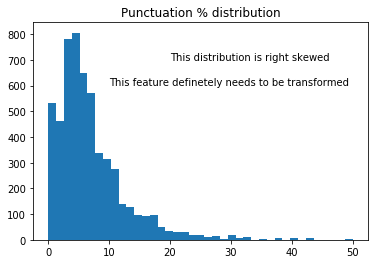

In [89]:
bins_to_use = np.linspace(0, 50, 40)
plt.hist(data['punct%'], bins=bins_to_use)
plt.title('Punctuation % distribution')
plt.annotate('This distribution is right skewed', xy=(20, 700))
_ = plt.annotate('This feature definetely needs to be transformed', xy=(10,600)) 

### TF-IDF

Creates a document-term matrix where the columns represent single unique terms (unigrams) but the cell represents a weighting meant to represent how important a word is to a document.

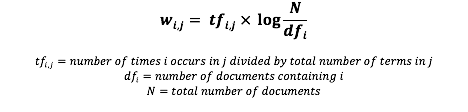

In [90]:
stopwords = nltk.corpus.stopwords.words('english')
def clean_text(text):
    text = ''.join([char for char in text if char not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

tfidf_vector = TfidfVectorizer(analyzer=clean_text)
X_tfidf = tfidf_vector.fit_transform(data['body_text'])

X_features = pd.concat([data['text_length'], data['punct%'], pd.DataFrame(X_tfidf.toarray())], axis=1)
X_features.head()

,text_length,punct%,0,1,2,3,4,5,6,7,...,8327,8328,8329,8330,8331,8332,8333,8334,8335,8336
0,160,2.500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,128,4.688,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,49,4.082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,62,3.226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,28,7.143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Explore RandomForestClassifier through Cross-Validation

In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
rf = RandomForestClassifier(n_jobs=-1)
k_fold = KFold(n_splits=5)
cross_val_score(rf, X_features, data['label'], cv=k_fold, scoring='accuracy', n_jobs=-1)

array([0.96768402, 0.96947935, 0.97127469, 0.96046721, 0.97484277])

#### Explore RandomForestClassifier through Holdout Set

In [93]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features, data['label'], test_size=0.2)

rf = RandomForestClassifier(n_estimators=50, max_depth=20, n_jobs=-1)
rf_model = rf.fit(X_train, y_train)

sorted(zip(rf_model.feature_importances_, X_train.columns), reverse=True)[0:10]

y_pred = rf_model.predict(X_test)
precision, recall, fscore, support = score(y_test, y_pred, pos_label='spam', average='binary')
print('Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3),
                                                        round(recall, 3),
                                                        round((y_pred==y_test).sum() / len(y_pred),3)))

Precision: 1.0 / Recall: 0.63 / Accuracy: 0.955


##### Build our own Grid-search

In [126]:
def train_RF(n_est, depth):
    rf = RandomForestClassifier(n_estimators=n_est, max_depth=depth, n_jobs=-1)
    rf_model = rf.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    precision, recall, fscore, support = score(y_test, y_pred, pos_label='spam', average='binary')
    print('Est: {} / Depth: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
        n_est, depth, round(precision, 3), round(recall, 3),
        round((y_pred==y_test).sum() / len(y_pred), 3)))   


In [127]:
for n_est in [10, 50, 100, 250]:
    for depth in [10, 20, 30, None]:
        train_RF(n_est, depth)

Est: 10 / Depth: 10 ---- Precision: 1.0 / Recall: 0.252 / Accuracy: 0.909
Est: 10 / Depth: 20 ---- Precision: 0.973 / Recall: 0.526 / Accuracy: 0.941
Est: 10 / Depth: 30 ---- Precision: 1.0 / Recall: 0.681 / Accuracy: 0.961
Est: 10 / Depth: None ---- Precision: 1.0 / Recall: 0.8 / Accuracy: 0.976
Est: 50 / Depth: 10 ---- Precision: 1.0 / Recall: 0.267 / Accuracy: 0.911
Est: 50 / Depth: 20 ---- Precision: 1.0 / Recall: 0.607 / Accuracy: 0.952
Est: 50 / Depth: 30 ---- Precision: 1.0 / Recall: 0.704 / Accuracy: 0.964
Est: 50 / Depth: None ---- Precision: 1.0 / Recall: 0.793 / Accuracy: 0.975
Est: 100 / Depth: 10 ---- Precision: 1.0 / Recall: 0.222 / Accuracy: 0.906
Est: 100 / Depth: 20 ---- Precision: 1.0 / Recall: 0.6 / Accuracy: 0.952
Est: 100 / Depth: 30 ---- Precision: 1.0 / Recall: 0.726 / Accuracy: 0.967
Est: 100 / Depth: None ---- Precision: 1.0 / Recall: 0.822 / Accuracy: 0.978
Est: 250 / Depth: 10 ---- Precision: 1.0 / Recall: 0.259 / Accuracy: 0.91
Est: 250 / Depth: 20 ---- Prec

#### Exploring parameter settings using GridSearchCV

In [130]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()
param = {'n_estimators': [10, 150, 300],
        'max_depth': [30, 60, 90, None]}

gs = GridSearchCV(rf, param, cv=5, n_jobs=-1)
gs_fit = gs.fit(X_features, data['label'])
pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
7,19.250064,0.656355,0.255600,0.024303,90,150,"{'max_depth': 90, 'n_estimators': 150}",0.977578,0.977558,0.976640,...,0.974677,0.004082,1,0.998877,0.999326,0.999551,0.999327,0.999327,0.999282,0.000220
10,18.841378,0.508120,0.253800,0.019343,None,150,"{'max_depth': None, 'n_estimators': 150}",0.975785,0.978456,0.974843,...,0.974677,0.004158,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,33.745918,1.165645,0.288800,0.028944,90,300,"{'max_depth': 90, 'n_estimators': 300}",0.976682,0.979354,0.974843,...,0.974138,0.004239,3,0.999551,0.999326,0.999102,0.999551,0.999551,0.999416,0.000180
11,28.164517,3.107703,0.235599,0.041865,None,300,"{'max_depth': None, 'n_estimators': 300}",0.975785,0.978456,0.974843,...,0.974138,0.003293,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
6,2.258710,0.116098,0.160799,0.028962,90,10,"{'max_depth': 90, 'n_estimators': 10}",0.979372,0.974865,0.976640,...,0.973779,0.004164,5,0.998653,0.998428,0.998878,0.997980,0.998204,0.998429,0.000317


#### Evaluate Gradient Boosting with GridSearchCV

In [133]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
param = {
    'n_estimators': [50, 100, 150], 
    'max_depth': [7, 11, 15],
    'learning_rate': [0.1]
}

clf = GridSearchCV(gb, param, cv=5, n_jobs=-1)
cv_fit = clf.fit(X_features, data['label'])
pd.DataFrame(cv_fit.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
2,201.526504,1.916767,0.224200,0.002926,0.1,7,150,"{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150}",0.967713,0.982047,...,0.971264,0.005538,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
7,290.125648,9.918563,0.193304,0.016822,0.1,15,100,"{'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 100}",0.968610,0.976661,...,0.970905,0.002931,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0
8,346.681407,8.502545,0.169928,0.017807,0.1,15,150,"{'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 150}",0.968610,0.977558,...,0.970905,0.003666,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0
5,313.989762,3.973477,0.232400,0.007392,0.1,11,150,"{'learning_rate': 0.1, 'max_depth': 11, 'n_estimators': 150}",0.965022,0.976661,...,0.970546,0.004220,4,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,142.808249,3.045927,0.228200,0.011461,0.1,7,100,"{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}",0.967713,0.981149,...,0.970366,0.005482,5,1.0,1.0,1.0,1.0,1.0,1.0,0.0


#### Now that we have evaluated the best performing model, let us split the data into train and test and then vectorize the text using the train data for test data.

In [136]:
data.columns

Index(['label', 'body_text', 'text_length', 'punct%'], dtype='object')

In [139]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['body_text', 'text_length', 'punct%']], data['label'], test_size=0.2)


tfidf_vect = TfidfVectorizer(analyzer=clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train['body_text'])

tfidf_train = tfidf_vect_fit.transform(X_train['body_text'])
tfidf_test = tfidf_vect_fit.transform(X_test['body_text'])

X_train_vect = pd.concat([X_train[['text_length', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['text_length', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.head()

,text_length,punct%,0,1,2,3,4,5,6,7,...,7345,7346,7347,7348,7349,7350,7351,7352,7353,7354
0,39,5.128,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,42,7.143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20,5.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,72,2.778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,57,5.263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Final evaluation of models

In [140]:
# Final evaluation of Random Forest Model
import time
rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1)

start = time.time()
rf_model = rf.fit(X_train_vect, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = rf_model.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label='spam', average='binary')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 1.87 / Predict time: 0.204 ---- Precision: 1.0 / Recall: 0.836 / Accuracy: 0.978


In [141]:
# Final evaluation of Gradient Bossting Model
gb = GradientBoostingClassifier(n_estimators=150, max_depth=11)

start = time.time()
gb_model = gb.fit(X_train_vect, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = gb_model.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label='spam', average='binary')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 165.064 / Predict time: 0.129 ---- Precision: 0.913 / Recall: 0.863 / Accuracy: 0.971


In [143]:
model_performance = pd.DataFrame({ 'Precision':[1.0, 0.913] ,
              'Recall': [.836, .863],
              'Fit Time': [1.87, 165.064] ,
              'Predict Time': [0.204, 0.129] ,
              'Accuracy':[.978, .971]   
                }, index=['RandomForestClassifier', 'GradientBoostingClassifier'])
model_performance

,Precision,Recall,Fit Time,Predict Time,Accuracy
RandomForestClassifier,1.000,0.836,1.870,0.204,0.978
GradientBoostingClassifier,0.913,0.863,165.064,0.129,0.971


### Based on the results shown, we can understand that the business can choose either of the model depending upon the criteria. If business wants to classify spams more aggresively, then gradient boosting classifier is a good choice. If the focus is more on the precsion, that is how many messages are classified as spam out of the total number of predictions made, then Random Forest classifier turns out to be the choice. Same goes for the prediction time in the sense that Random forest takes more prediction time but less time to fit the model.